# State Independent Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO)
        trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
n_all_samples = np.shape(U1)[0]
n_burn_in = 20
n_samples= 150
n_acquisition = 50
n_parameters_optimizing = 2 # here we are optimizing freq. and amp.
n_all_parameters = 3 # freq amp and preStimGamma
print(n_all_samples)

384


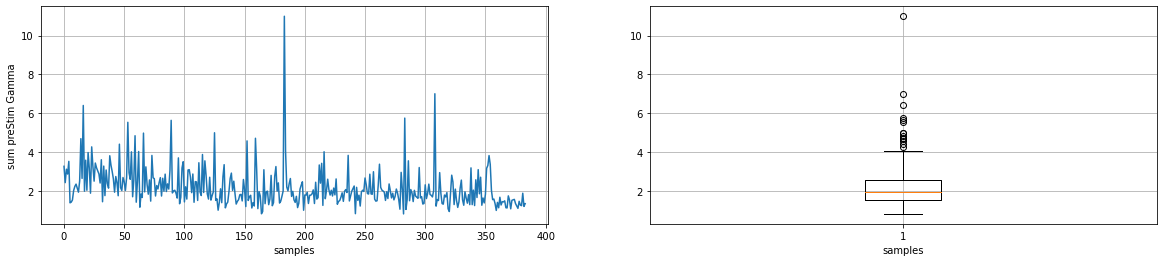

In [77]:


fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.plot(np.arange(0, n_all_samples), X0_psd['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("sum preStim Gamma")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.boxplot(X0_psd['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("")
plt.grid(visible=True)

plt.show();

In [75]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.75)
# max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n 3rd Quartile preStimGamma is:", 
      third_quartile_sum_preStim_gamma)
half_n_samples = int(n_acquisition/2)
step_size = np.round((third_quartile_sum_preStim_gamma-min_sum_preStim_gamma)/half_n_samples,6)
hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)
hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.arange(third_quartile_sum_preStim_gamma,
                                                                     min_sum_preStim_gamma, -step_size)

print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 3rd Quartile preStimGamma is: 2.5742740008887974
[0.81379952 0.88421852 0.95463752] (50,)


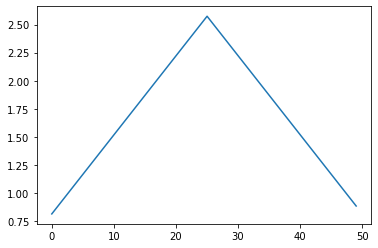

In [33]:
plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma);

In [34]:
print('freq and amplitude used are: \n', U1[0:4])

freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [35]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [37]:
print(np.shape(U1))

(384, 2)


## 1.2 First BaO Model is trained on all of the dataset

In [38]:
ker_BaO = GPy.kern.Matern52(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [39]:
slice_dim = 1
ylabel='Predicted Gamma'

#### 1.2.1: The first model uses sum_preStim_gamma.

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1525008bc10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1525008bfd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0002   3.186270e+03   3.204701e+05 
    02s24  0026   1.111469e+03   1.025215e-02 
    02s93  0034   1.111442e+03   3.171993e-09 
Runtime:     02s93
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x15250490370>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15250449d60>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1524f9c6ca0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1524f9cf8e0>]}

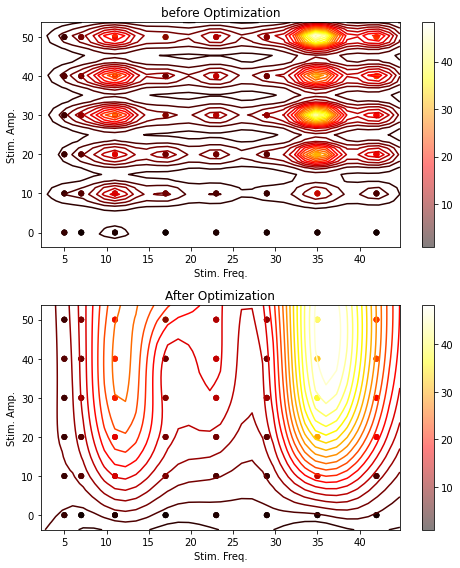

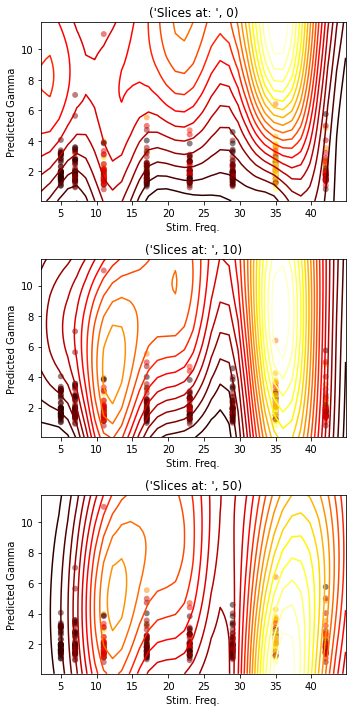

In [40]:
# x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

# input_data
U1_X0 = U1.join(X0_psd)

# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1_X0,X1,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
canvas_optimized = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas_slices);

## 1.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [41]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [42]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [43]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [44]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0004   4.852573e+02   3.345151e+03 
    00s06  0011   8.975792e+01   2.859550e-01 
    00s08  0015   7.852118e+01   2.586189e-03 
    00s09  0017   7.638703e+01   4.158534e-03 
    00s19  0033   7.033422e+01   2.265664e-02 
    00s28  0053   6.946105e+01   2.090506e-10 
Runtime:     00s28
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15250819880>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15250839850>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x15250e916a0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x15250e91be0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x15250e91c10>]}

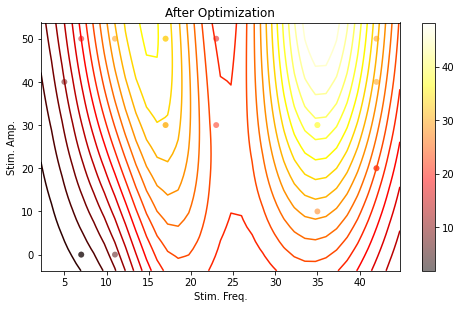

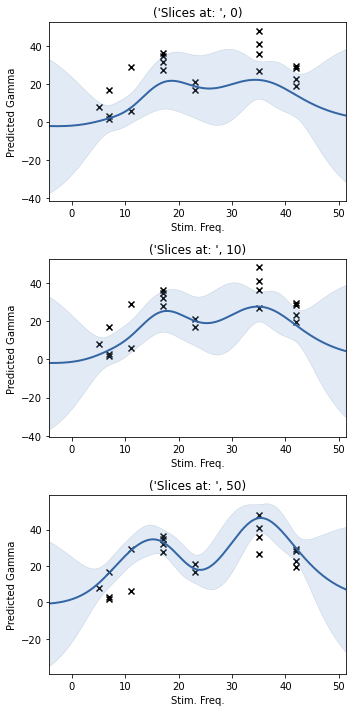

In [45]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [46]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  2  2  2  3  3  4  4  4  4  4  5  5  5  6  6  6  6  6  7  8  8  8  8
  8  8  9 10 10 11 11 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 15 16
 16 17 17 17 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 20 20 20 20
 20 20 21 21 21 21 21 21 22 23 23 23 23 23 23 25 25 25 25 25 26 26 26 26
 27 27 27 27 28 28 28 28 28 29 30 30 30 30 31 31 32 32 32 33 33 33 33 34
 34 35 35 35 35 36 36 36 37 37 37 37 37 38 38 39 39 39 40 40 40 40 40 40
 41 41 42 42 42 42]
[ 1  1  1  1  2  3  4  4  4  4  5  5  5  5  5  5  6  6  6  8  8  9 10 10
 10 10 10 11 11 11 11 12 12 13 13 13 13 14 14 14 15 15 15 15 15 15 15 15
 16 16 16 16 17 17 17 17 18 18 18 18 19 19 19 19 19 20 21 21 21 22 22 23
 23 23 23 23 24 24 26 27 27 27 27 28 28 28 28 28 29 29 29 29 30 30 30 30
 31 31 31 31 31 31 32 32 33 33 34 34 35 35 38 38 38 38 38 39 39 40 40 40
 41 41 42 43 43 44 44 44 44 45 45 46 46 46 46 46 46 47 47 47 47 48 48 48
 49 49 50 50 50 50] (150,)


In [48]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(np.shape(testX))

(150,) (150,)
(2, 150)
(150, 2)


In [55]:
print(np.shape(hill_sum_preStim_gamma[0:1]), hill_sum_preStim_gamma[0:1])
ucb_sample[1,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[0:1], axis=0)

(1,) [0.81379952]


In [56]:
# a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
ucb = np.empty((1, n_samples))
ucb_sample = np.empty((n_acquisition, n_all_parameters))
postStimGamma_predicted_from_firstModel = np.empty((n_acquisition, 1))
print(np.shape(ucb))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);
    
    ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
    max_ucb = np.max(ucb, axis=0)
    argMax_ucb = ucb.argmax()

    # find the values of argMax_ucb in the sample grid
    ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
    ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
    print(ucb_sample_reshaped)
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
    U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel[a]]
    X1_init = np.append(X1_init, next_postStimGamma, axis=0)
    
    # trained_model_BaO_AF.add_observer()
    trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF)
    
    

(1, 150)
nu set at:  0.1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0005   7.471057e+01   6.428671e-04 
    00s13  0017   7.467652e+01   6.904902e-06 
    00s18  0027   7.466451e+01   3.616597e-05 
    00s19  0029   7.466434e+01   1.489063e-08 
    00s21  0033   7.466433e+01   3.097158e-10 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   7.820497e+01   3.375041e-05 
    00s06  0011   7.820365e+01   3.103113e-07 
    00s13  0021   7.819625e+01   2.668759e-07 
    00s17  0026   7.819624e+01   3.175379e-12 
Runtime:     00s17
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0007   8.091194e+01   9.426872e-07 
    00s07  0010   8.091165e+01   5.942395e-06 
    00s08  0011   8.091160e+01   4.320680e-07 
    00s15  0023   8.091062e+01   

#### 1.3.3: Plot before and after optimization 

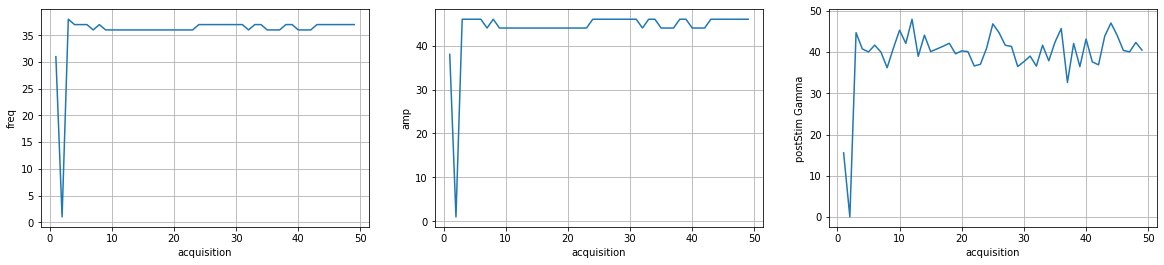

In [57]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [58]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[31.  1. 38. 37. 37. 37. 36. 37. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 37. 37. 37. 37. 37. 37. 37. 37. 36. 37. 37. 36. 36.
 36. 37. 37. 36. 36. 36. 37. 37. 37. 37. 37. 37. 37.]
[38.  1. 46. 46. 46. 46. 44. 46. 44. 44. 44. 44. 44. 44. 44. 44. 44. 44.
 44. 44. 44. 44. 44. 46. 46. 46. 46. 46. 46. 46. 46. 44. 46. 46. 44. 44.
 44. 46. 46. 44. 44. 44. 46. 46. 46. 46. 46. 46. 46.]


In [59]:
print(postStimGamma_predicted_from_firstModel[1:10])

[[15.60755105]
 [ 0.08072058]
 [44.72926706]
 [40.80130753]
 [40.067303  ]
 [41.71438191]
 [40.03319879]
 [36.23864526]
 [40.97118942]]


### 1.4: Dynamic BaO

In [60]:
dynamic_model = state_dr_gp()

In [61]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [62]:
U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)


In [63]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [64]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [65]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0007   2.155162e+02   9.304256e+01 
    00s11  0013   8.225640e+01   2.768416e-02 
    00s19  0025   3.191608e+06   5.082507e+12 
    00s28  0053   6.946105e+01   2.090506e-10 
Runtime:     00s28
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15257d9b310>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x15250fae610>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x152580ec6a0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x152580ecbe0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x152580dc670>]}

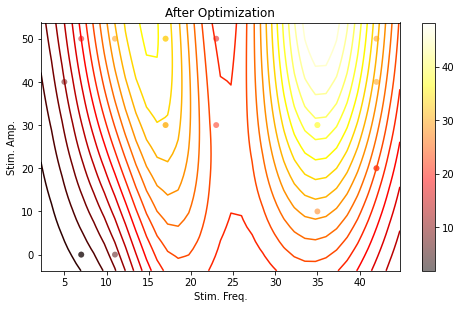

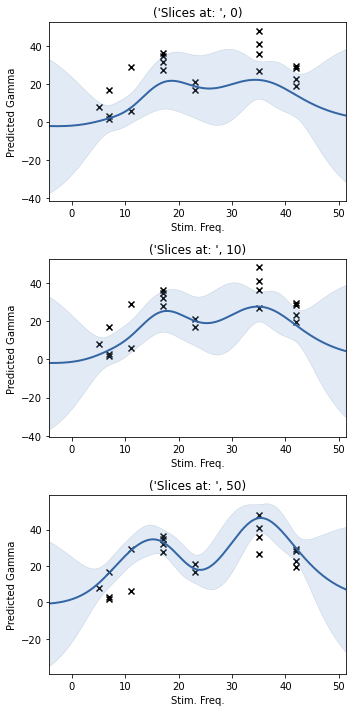

In [66]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [77]:
print(np.shape(testX_Dynamic_BaO))

(2, 150)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [69]:
ucb_dynamic = np.empty((1, n_samples))
ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
postStimGamma_predicted_from_firstModel_dynamic = np.empty((n_acquisition, 1))
print(np.shape(ucb_dynamic))
model_sample_dynamic = np.empty((n_acquisition, n_parameters_optimizing))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_dynamic = np.empty((1, n_samples))
    simMse_BaO_dynamic = np.empty((1, n_samples))
    
    simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);
    
    argMax_model = simY_BaO_dynamic.argmax()
    print("model's argMax index: ", argMax_model)
    model_values = testX[argMax_model]
    print("model values", model_values)
    model_sample_dynamic[a,:] = model_values
    
    ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
    max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
    print(max_ucb_dynamic)
    argMax_ucb_dynamic = ucb_dynamic.argmax()
    print(argMax_ucb_dynamic)
    # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
    ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
    print(ucb_sample_dynamic[a,:])
    ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
    print(ucb_sample_reshaped)
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    print(postStimGamma_predicted_from_firstModel_dynamic[a])
    # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
    U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
    U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_burn_in),:]
    
#     # sum_preStim_gamma
#     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
#     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
#     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel_dynamic[a]]
    X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
    print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))
    
    X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_burn_in),:]
    print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
    
    

(1, 150)
nu set at:  0.1
model's argMax index:  125
model values [36 44]
[51.00300118]
110
[31.         38.          0.88421852]
[[31.         38.          0.88421852]]
[20.13877067]
X1_init_dynamic shape is:  (21, 1)
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   6.900454e+01   5.089340e-05 
    00s07  0011   6.899104e+01   1.472172e-07 
    00s16  0026   6.898689e+01   3.784050e-07 
    00s18  0029   6.898689e+01   8.795715e-09 
    00s19  0031   6.898689e+01   7.167507e-11 
Runtime:     00s19
Optimization status: Converged

model's argMax index:  131
model values [37 46]
[53.86896202]
133
[38.         46.          0.95463752]
[[38.         46.          0.95463752]]
[42.43070346]
X1_init_dynamic shape is:  (22, 1)
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0005   6.920083e+01   3.635003e-05 
    00s09  0010   6.919147e+01   3.17212

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


    00s19  0013   6.512541e+01   2.004191e-04 
    00s39  0029   6.511729e+01   4.109748e-11 
Runtime:     00s39
Optimization status: Converged

model's argMax index:  125
model values [36 44]
[52.41266352]
110
[31.         38.          2.36301752]
[[31.         38.          2.36301752]]
[14.76171055]
X1_init_dynamic shape is:  (42, 1)
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   6.727926e+01   3.919576e-02 
    00s11  0008   6.714078e+01   1.002953e-04    00s09  0007   6.714304e+01   2.413880e-05 
    00s19  0014   6.708958e+01   1.882727e-02 
    00s55  0052   6.674758e+01   6.189975e-12 
Runtime:     00s55
Optimization status: Converged

model's argMax index:  131
model values [37 46]
[46.06901356]
131
[37.         46.          2.43343652]
[[37.         46.          2.43343652]]
[35.2302676]
X1_init_dynamic shape is:  (43, 1)
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i   

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


model's argMax index:  131
model values [37 46]
[45.21174822]
133
[38.       46.        2.433436]
[[38.       46.        2.433436]]
[39.60205761]
X1_init_dynamic shape is:  (47, 1)
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.731161e+01           nan 
    00s01  0002   6.725329e+01   5.598706e-04 
    00s09  0010   6.723406e+01   4.185119e-04 
    00s21  0018   6.717839e+01   1.459687e-11 
Runtime:     00s21
Optimization status: Converged

model's argMax index:  137
model values [39 47]
[65.48454413]
146
[42.       50.        2.363017]
[[42.       50.        2.363017]]
[26.9018735]
X1_init_dynamic shape is:  (48, 1)
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0005   6.819695e+01   3.559481e-05    00s04  0003   6.819846e+01   2.138714e-04 
    00s10  0007   6.819623e+01   1.800681e-06 
    00s19  0016   6.825323e+01   1.203751e-02 

In [70]:
testX[argMax_ucb_dynamic]

array([42, 50])

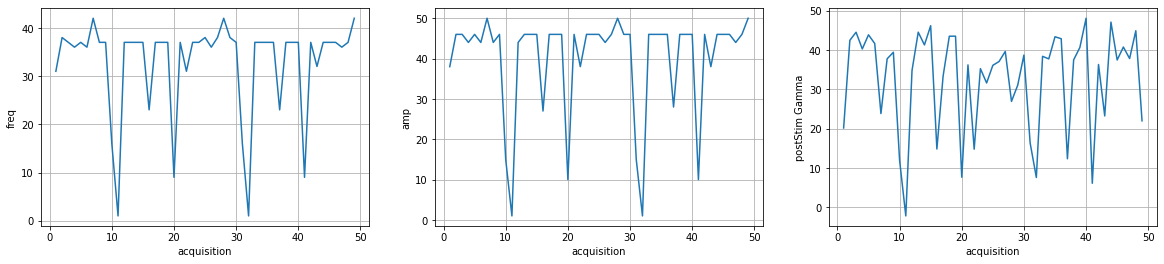

In [71]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel_dynamic[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)
plt.show()

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x15259614d60>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x152595eee20>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x152599f4580>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x152599f49a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x152599f49d0>]}

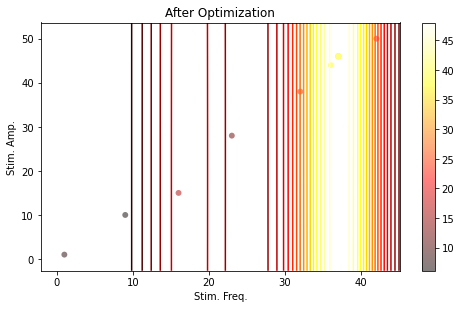

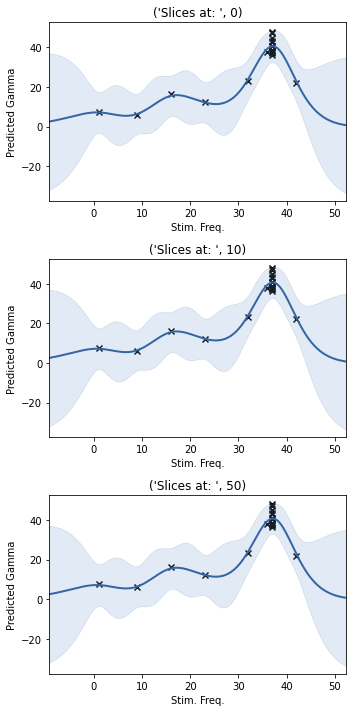

In [72]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: comparing static and dynamic BaO

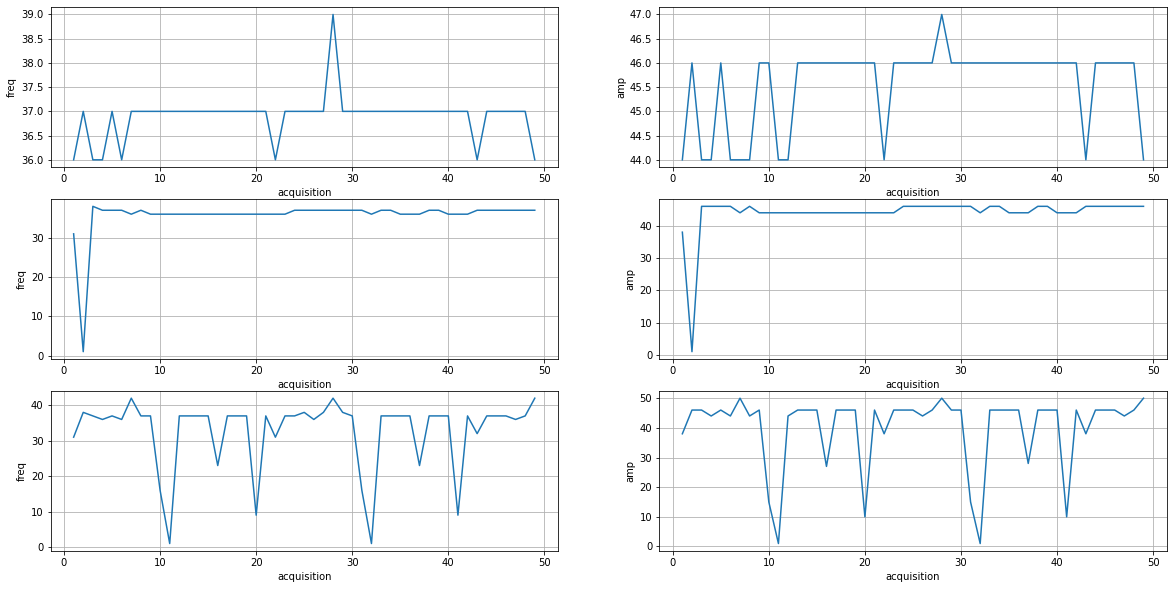

In [73]:
fig = plt.figure(figsize=(20,10));
fig.title = ("Simulation vs. Static vs. Dynamic BaO")
plt.subplot(3,2,1)
plt.plot(np.arange(1,50), model_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(3,2,2)
plt.plot(np.arange(1,50), model_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(3,2,3)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(3,2,4)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(3,2,5)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(3,2,6)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.show()


#### 1.5.1 Comparing Models and Acquisition Functions optimum freq and amp to stimulate at

x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function pseudo code and draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end